In [1]:
import sys
import os

# Go up to project root (from inside training/)
project_root = os.path.abspath(os.path.join(os.getcwd(), '../..'))
if project_root not in sys.path:
    sys.path.append(project_root)

In [2]:
import numpy as np
import torch
import torch.nn as nn
import gc
import random
from core.models.hierarchical_transformer import HierarchicalTransformer
from core.utils import create_transformer_dataset, generate_model_filename, TransformerLRScheduler
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import os
import time


In [3]:
def initial_cleanup():
    # Memory cleanup
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.ipc_collect()
    gc.collect()
    
    # Set random seeds
    random.seed(69)
    np.random.seed(69)
    torch.manual_seed(69)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(69)
        torch.cuda.manual_seed_all(69)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
    print("Clean slate initialized!")

# Call this at the top of your notebook
initial_cleanup()

Clean slate initialized!


In [4]:
X_np, y_np, attention_masks_np, sequence_lengths_np = create_transformer_dataset(data_dir="../../data/keypoints",verbose=False)

Using max_frames = 200 (95.0th percentile)
Sequence length stats - Min: 0, Max: 404
Filtering out sample with length 236
Filtering out sample with length 236
Filtering out sample with length 267
Filtering out sample with length 267
Filtering out sample with length 237
Filtering out sample with length 237
Filtering out sample with length 248
Filtering out sample with length 248
Filtering out sample with length 207
Filtering out sample with length 207
Filtering out sample with length 219
Filtering out sample with length 219
Filtering out sample with length 280
Filtering out sample with length 280
Filtering out sample with length 249
Filtering out sample with length 249
Filtering out sample with length 247
Filtering out sample with length 247
Filtering out sample with length 210
Filtering out sample with length 210
Filtering out sample with length 215
Filtering out sample with length 215
Filtering out sample with length 283
Filtering out sample with length 283
Filtering out sample with le

In [5]:
# Convert to PyTorch tensors
X_np = X_np[:, :, :, :3]  # shape: (N, F, J, 3)
attention_masks_np = attention_masks_np  # shape: (N, F)

# First split: TrainVal vs Test
X_temp, X_test, y_temp, y_test, mask_temp, mask_test = train_test_split(
    X_np, y_np, attention_masks_np, 
    test_size=0.1, random_state=69, stratify=y_np
)

# Second split: Train vs Val
val_ratio = 0.1 / 0.9  # same as before
X_train, X_val, y_train, y_val, mask_train, mask_val = train_test_split(
    X_temp, y_temp, mask_temp, 
    test_size=val_ratio, random_state=69, stratify=y_temp
)

# Convert to tensors
X_train = torch.from_numpy(X_train).float()
X_val = torch.from_numpy(X_val).float()
X_test = torch.from_numpy(X_test).float()

y_train = torch.from_numpy(y_train).long()
y_val = torch.from_numpy(y_val).long()
y_test = torch.from_numpy(y_test).long()

mask_train = torch.from_numpy(mask_train).float()
mask_val = torch.from_numpy(mask_val).float()
mask_test = torch.from_numpy(mask_test).float()

# Create datasets
train_dataset = TensorDataset(X_train, y_train, mask_train)
val_dataset = TensorDataset(X_val, y_val, mask_val)
test_dataset = TensorDataset(X_test, y_test, mask_test)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)
test_loader = DataLoader(test_dataset, batch_size=16)

In [6]:
parameters = dict(
    num_joints=33,
    num_frames=200,
    d_model=64,
    nhead=2,
    num_spatial_layers=1,
    num_temporal_layers=1,
    num_classes=3,
    dim_feedforward=256,
    dropout=0.1
)

epochs = 60

num_steps_per_epoch = len(train_loader)
warmup_steps = int(0.1 * num_steps_per_epoch * epochs)

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = HierarchicalTransformer(**parameters).to(device)

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.AdamW(model.parameters(), lr=1e-2, betas=(0.9, 0.98), eps=1e-9, weight_decay=1e-5) # weight_decay=1e-4
scheduler = TransformerLRScheduler(optimizer, d_model=parameters['d_model'], warmup_steps=warmup_steps)

In [8]:

train_loss_history = []
val_loss_history = []

train_acc_history = []
val_acc_history = []

patience = 5  # Number of epochs to wait for improvement
best_val_loss = float('inf')
epochs_no_improve = 0

for epoch in range(epochs):
    start_time = time.time()  # Start timer
    
    model.train()
    train_loss = 0
    correct = 0

    for X_batch, y_batch, mask_batch in train_loader:
        
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        mask_batch = mask_batch.to(device)

        optimizer.zero_grad()
        outputs = model(x=X_batch, temporal_mask=mask_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        scheduler.step()
        

        train_loss += loss.item() * X_batch.size(0)
        correct += (outputs.argmax(1) == y_batch).sum().item()

    train_loss /= len(train_loader.dataset)
    train_acc = correct / len(train_loader.dataset)
    
    train_loss_history.append(train_loss)
    train_acc_history.append(train_acc)

     # ---------- VALIDATION ----------
    model.eval()
    val_loss = 0
    val_correct = 0
    with torch.no_grad():
        for X_batch, y_batch, mask_batch in val_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            mask_batch = mask_batch.to(device)
            
            outputs = model(x=X_batch, temporal_mask=mask_batch)
            loss = criterion(outputs, y_batch)

            val_loss += loss.item() * X_batch.size(0)
            val_correct += (outputs.argmax(1) == y_batch).sum().item()

    val_loss /= len(val_loader.dataset)
    
    val_acc = val_correct / len(val_loader.dataset)
    
    val_loss_history.append(val_loss)
    val_acc_history.append(val_acc)
    
    end_time = time.time()  # End timer
    epoch_time = end_time - start_time
    
    minutes = int(epoch_time // 60)
    seconds = epoch_time % 60

    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f} | Time: {minutes}m {seconds:.2f}s")
    
    # ---------- EARLY STOPPING ----------
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= patience:
        print(f"Early stopping triggered at epoch {epoch+1}.")
        break

d:\Thesis\thesis\Lib\site-packages\torch\nn\modules\transformer.py:505: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. We recommend specifying layout=torch.jagged when constructing a nested tensor, as this layout receives active development, has better operator coverage, and works with torch.compile. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\NestedTensorImpl.cpp:182.)
  output = torch._nested_tensor_from_mask(


Epoch 1/60 | Train Loss: 1.1082, Acc: 0.2767 | Val Loss: 1.0988, Acc: 0.4009 | Time: 0m 34.61s
Epoch 2/60 | Train Loss: 1.0937, Acc: 0.4141 | Val Loss: 1.0845, Acc: 0.4245 | Time: 0m 34.64s
Epoch 3/60 | Train Loss: 1.0771, Acc: 0.4419 | Val Loss: 1.0653, Acc: 0.4104 | Time: 0m 35.00s
Epoch 4/60 | Train Loss: 1.0534, Acc: 0.4727 | Val Loss: 1.0323, Acc: 0.5094 | Time: 0m 34.93s
Epoch 5/60 | Train Loss: 1.0147, Acc: 0.5450 | Val Loss: 0.9861, Acc: 0.7500 | Time: 0m 35.03s
Epoch 6/60 | Train Loss: 0.9449, Acc: 0.6724 | Val Loss: 0.8709, Acc: 0.7830 | Time: 0m 35.14s
Epoch 7/60 | Train Loss: 0.8201, Acc: 0.7583 | Val Loss: 0.7270, Acc: 0.8255 | Time: 0m 35.10s
Epoch 8/60 | Train Loss: 0.7027, Acc: 0.8098 | Val Loss: 0.6277, Acc: 0.8396 | Time: 0m 35.22s
Epoch 9/60 | Train Loss: 0.6215, Acc: 0.8501 | Val Loss: 0.5671, Acc: 0.8774 | Time: 0m 35.05s
Epoch 10/60 | Train Loss: 0.5768, Acc: 0.8685 | Val Loss: 0.5281, Acc: 0.8962 | Time: 0m 35.11s
Epoch 11/60 | Train Loss: 0.5412, Acc: 0.8910 | V

In [9]:
# Switch to eval mode
model.eval()

# Collect all predictions and true labels
all_preds = []
all_labels = []

with torch.no_grad():
    for X_batch, y_batch, mask_batch in test_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        mask_batch = mask_batch.to(device)

        # If your model uses the mask in forward()
        outputs = model(X_batch, mask_batch)

        preds = outputs.argmax(1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y_batch.cpu().numpy())

# Generate classification report
report = classification_report(all_labels, all_preds, target_names=['squats', 'deadlifts', 'shoulder_press'])
print(report)

                precision    recall  f1-score   support

        squats       0.91      0.96      0.94        85
     deadlifts       0.95      0.97      0.96        62
shoulder_press       1.00      0.91      0.95        65

      accuracy                           0.95       212
     macro avg       0.95      0.95      0.95       212
  weighted avg       0.95      0.95      0.95       212



[[82  3  0]
 [ 2 60  0]
 [ 6  0 59]]


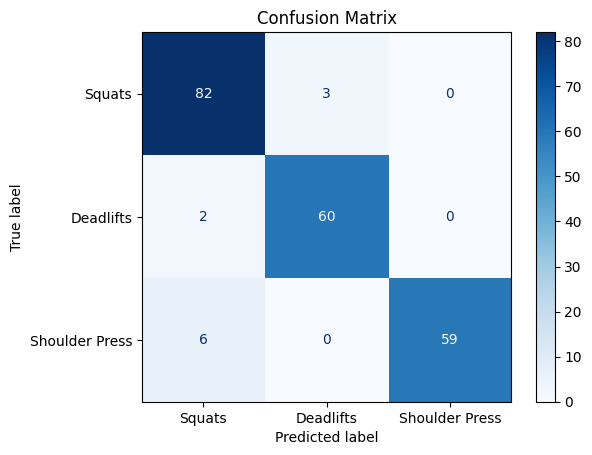

In [10]:
matrix = confusion_matrix(all_labels, all_preds)
print(matrix)

class_names = ['Squats', 'Deadlifts', 'Shoulder Press']

ConfusionMatrixDisplay.from_predictions(all_labels, all_preds,
                                        display_labels=class_names,
                                        cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

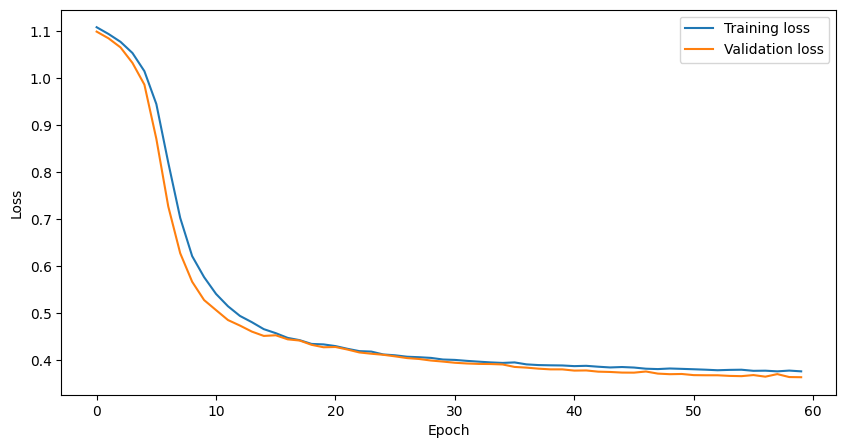

In [11]:
# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_loss_history, label='Training loss')
plt.plot(val_loss_history, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

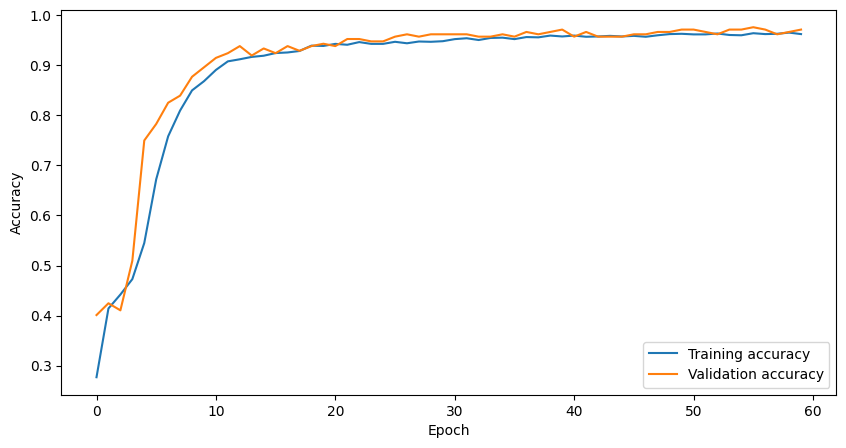

In [12]:
plt.figure(figsize=(10, 5))
plt.plot(train_acc_history, label='Training accuracy')
plt.plot(val_acc_history, label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [13]:
# Save model to disk
# OLD
# torch.save(model.state_dict(), '../../models/hierarchical transformer/hierarchical_transformer_v2_weights_2025-06-23_complete.pth')

In [14]:
model_name = "hierarchical_transformer"
filename = generate_model_filename(base_name=model_name, params=parameters)
# Save
save_path = os.path.join("../../models", model_name, filename)
os.makedirs(os.path.dirname(save_path), exist_ok=True)
torch.save(model.state_dict(), save_path)
